# Medicinal Data Analysis and Predictive Modeling

This notebook performs data analysis and predictive modeling on a dataset of medicines. The goal is to explore the data, engineer features, perform clustering, analyse sentiment, and build predictive models to understand the factors influencing medicine success.

## Table of Contents

1. Data Loading and Initial Inspection
2. Data Cleaning
3. Feature Engineering
4. Exploratory Data Analysis
5. Clustering Analysis
6. Sentiment Analysis
7. Predictive Modeling

## 1. Data Loading and Initial Inspection

In this section, we load the data and inspect the first few rows to understand the structure of the dataset.

In [8]:
# Importing necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from textblob import TextBlob
import spacy
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import time
import warnings
from sklearn.tree import plot_tree
warnings.filterwarnings("ignore")


In [9]:
# Load the data
file_path = 'Medicine_Details.csv'
medicine_data = pd.read_csv(file_path)
medicine_data.head()

,Medicine Name,Composition,Uses,Side_effects,Image URL,Manufacturer,Excellent Review %,Average Review %,Poor Review %
0,Avastin 400mg Injection,Bevacizumab (400mg),Cancer of colon and rectum Non-small cell lun...,Rectal bleeding Taste change Headache Noseblee...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Roche Products India Pvt Ltd,22,56,22
1,Augmentin 625 Duo Tablet,Amoxycillin (500mg) + Clavulanic Acid (125mg),Treatment of Bacterial infections,Vomiting Nausea Diarrhea Mucocutaneous candidi...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glaxo SmithKline Pharmaceuticals Ltd,47,35,18
2,Azithral 500 Tablet,Azithromycin (500mg),Treatment of Bacterial infections,Nausea Abdominal pain Diarrhea,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Alembic Pharmaceuticals Ltd,39,40,21
3,Ascoril LS Syrup,Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...,Treatment of Cough with mucus,Nausea Vomiting Diarrhea Upset stomach Stomach...,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Glenmark Pharmaceuticals Ltd,24,41,35
4,Aciloc 150 Tablet,Ranitidine (150mg),Treatment of Gastroesophageal reflux disease (...,Headache Diarrhea Gastrointestinal disturbance,"https://onemg.gumlet.io/l_watermark_346,w_480,...",Cadila Pharmaceuticals Ltd,34,37,29


## 2. Data Cleaning

In this section, we check for missing values and duplicate rows, and then clean the data by removing duplicates and dropping unnecessary columns.

In [12]:
# Check data types and missing values
data_types = medicine_data.dtypes
missing_values = medicine_data.isnull().sum()
duplicate_rows = medicine_data.duplicated().sum()

print("Missing values:", missing_values)
print("Number of duplicate rows:", duplicate_rows)

# Remove duplicate rows
medicine_data_no_duplicates = medicine_data.drop_duplicates()
duplicate_rows_after_removal = medicine_data_no_duplicates.duplicated().sum()

print("Number of duplicate rows after removal:", duplicate_rows_after_removal)

# Drop unnecessary columns
medicine_data_cleaned = medicine_data_no_duplicates.drop(columns=['Image URL'])

Missing values: Medicine Name         0
Composition           0
Uses                  0
Side_effects          0
Image URL             0
Manufacturer          0
Excellent Review %    0
Average Review %      0
Poor Review %         0
dtype: int64
Number of duplicate rows: 84
Number of duplicate rows after removal: 0


## 3. Feature Engineering

In this section, we create a composite score based on review percentages and extract dosages from the composition column.

In [15]:
# Creating composite score based on review percentages
medicine_data_cleaned['Composite Score'] = (
    medicine_data_cleaned['Excellent Review %'] * 2 +
    medicine_data_cleaned['Average Review %'] * 1 +
    medicine_data_cleaned['Poor Review %'] * 0
) / 3
medicine_data_cleaned.head(20)

# Extracting and converting dosages from composition
def extract_and_convert_dosage(composition):
    mg_dosages = re.findall(r'(\d+(?:\.\d+)?)\s*mg', composition)
    mcg_dosages = re.findall(r'(\d+(?:\.\d+)?)\s*mcg', composition)
    total_mg = sum(float(mg) for mg in mg_dosages) + sum(float(mcg) / 1000 for mcg in mcg_dosages)
    return total_mg

def clean_composition(composition):
    return re.sub(r'\s*\(.*?\s*(?:mg|mcg|ml)\)', '', composition).strip()

medicine_data_cleaned['Dosage_mg'] = medicine_data_cleaned['Composition'].apply(extract_and_convert_dosage)
medicine_data_cleaned['Cleaned_Composition'] = medicine_data_cleaned['Composition'].apply(clean_composition)
medicine_data_cleaned[['Medicine Name', 'Composite Score', 'Dosage_mg']].head(10)

,Medicine Name,Composite Score,Dosage_mg
0,Avastin 400mg Injection,33.333333,400.0
1,Augmentin 625 Duo Tablet,43.000000,625.0
2,Azithral 500 Tablet,39.333333,500.0
3,Ascoril LS Syrup,29.666667,81.0
4,Aciloc 150 Tablet,35.000000,150.0
5,Allegra 120mg Tablet,37.333333,120.0
6,Avil 25 Tablet,38.000000,25.0
7,Aricep 5 Tablet,38.000000,5.0
8,Amoxyclav 625 Tablet,38.333333,625.0
9,Atarax 25mg Tablet,37.000000,25.0


## 4. Exploratory Data Analysis

In this section, we generate summary statistics and visualize the distributions of review percentages and composite scores.


Summary Statistics:        Excellent Review %  Average Review %  Poor Review %  Composite Score  \
count        11741.000000      11741.000000   11741.000000     11741.000000   
mean            38.505068         35.783494      25.711439        37.597876   
std             25.192156         18.264038      23.949109        15.212692   
min              0.000000          0.000000       0.000000         0.000000   
25%             22.000000         27.000000       0.000000        29.333333   
50%             34.000000         35.000000      22.000000        37.666667   
75%             51.000000         47.000000      35.000000        47.333333   
max            100.000000         88.000000     100.000000        66.666667   

          Dosage_mg  
count  11741.000000  
mean     158.339144  
std      268.918649  
min        0.000000  
25%        1.500000  
50%       40.000000  
75%      200.000000  
max     4500.000000  


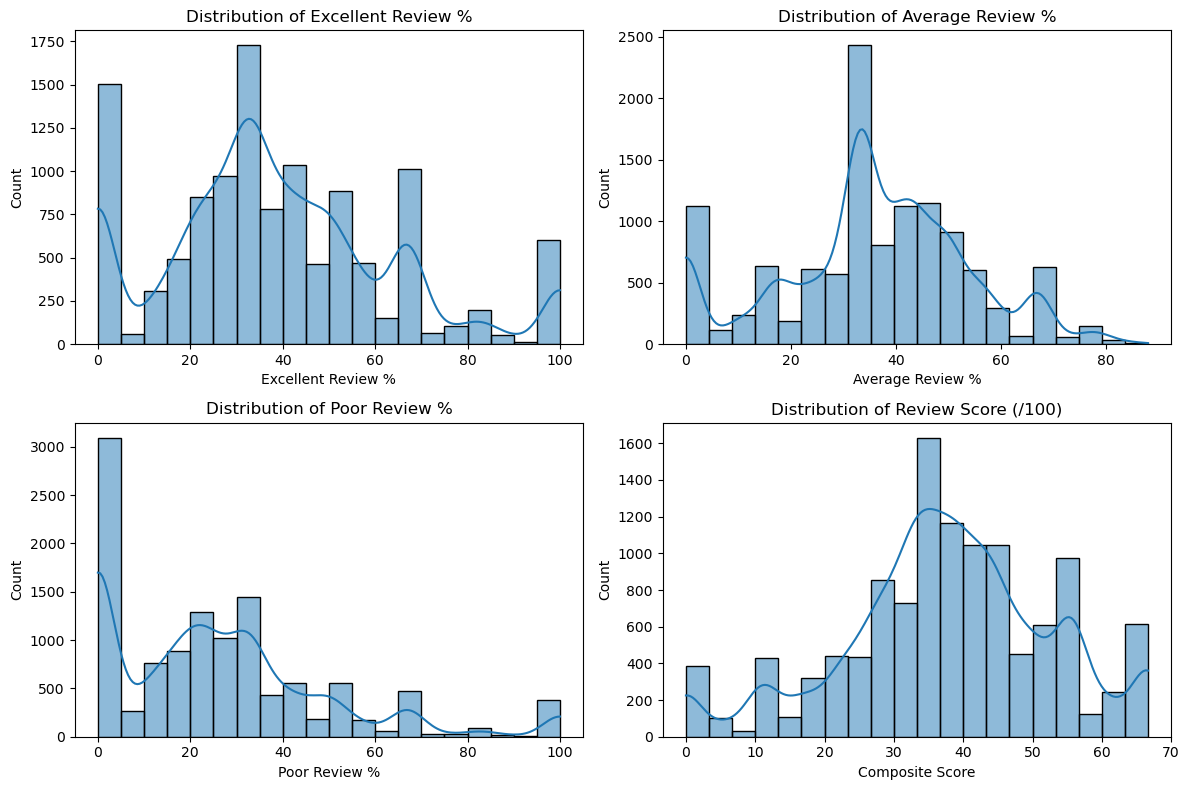

In [18]:
# Summary statistics and distribution plots
summary_statistics = medicine_data_cleaned.describe()
print("Summary Statistics:", summary_statistics)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(medicine_data_cleaned['Excellent Review %'], bins=20, kde=True)
plt.title('Distribution of Excellent Review %')

plt.subplot(2, 2, 2)
sns.histplot(medicine_data_cleaned['Average Review %'], bins=20, kde=True)
plt.title('Distribution of Average Review %')

plt.subplot(2, 2, 3)
sns.histplot(medicine_data_cleaned['Poor Review %'], bins=20, kde=True)
plt.title('Distribution of Poor Review %')

plt.subplot(2, 2, 4)
sns.histplot(medicine_data_cleaned['Composite Score'], bins=20, kde=True)
plt.title('Distribution of Review Score (/100)')

plt.tight_layout()
plt.show()


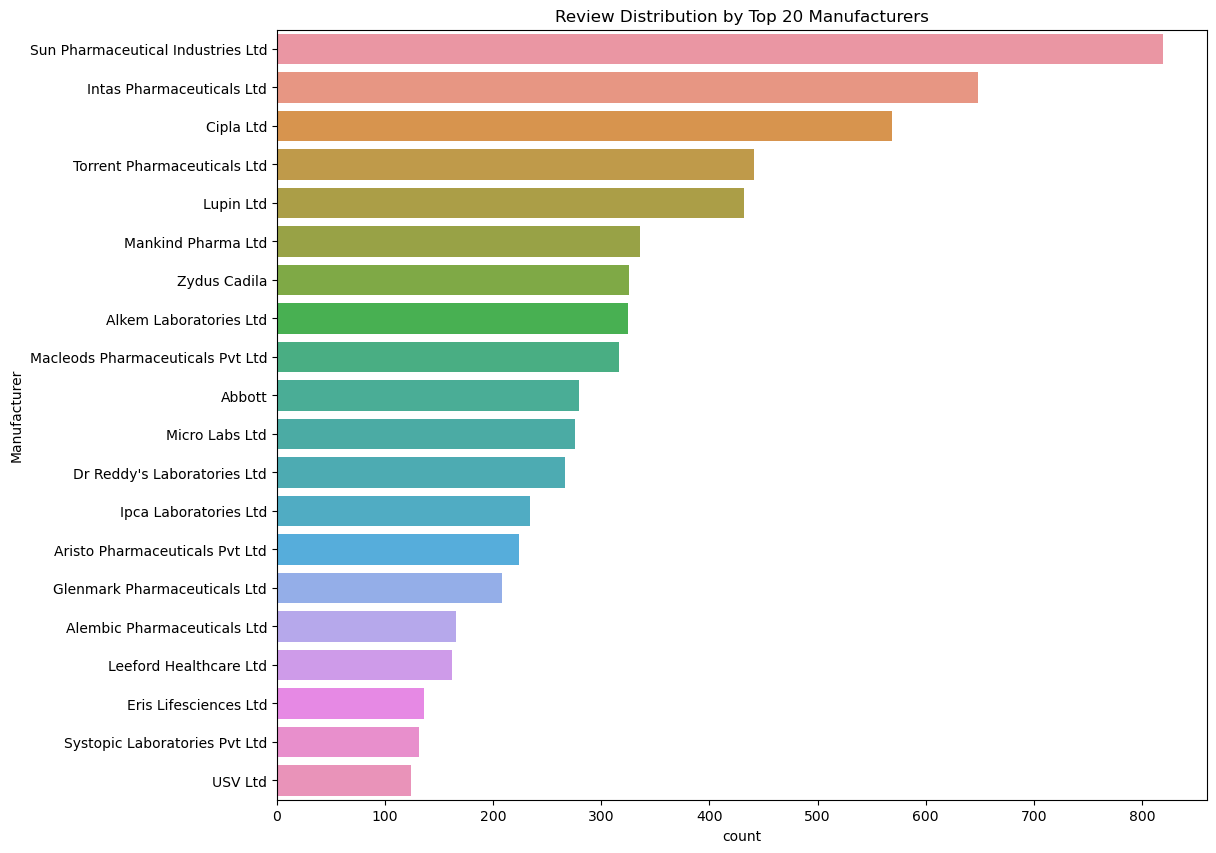

In [19]:
# Top 20 manufacturers by review distribution
top_20_manufacturers = medicine_data_cleaned['Manufacturer'].value_counts().nlargest(20).index

plt.figure(figsize=(12, 10))  
sns.countplot(y='Manufacturer', data=medicine_data_cleaned[medicine_data_cleaned['Manufacturer'].isin(top_20_manufacturers)], order=top_20_manufacturers)
plt.title("Review Distribution by Top 20 Manufacturers")
plt.show()

## 5. Clustering Analysis

In this section, we preprocess the side effects text data, perform K-means clustering, and visualize clusters using t-SNE.

Loading spacy model...
Model loaded.
Preprocessing side effects...
Preprocessing complete. Time taken: 81.19 seconds
Vectorizing side effects...
Vectorization complete. Time taken: 0.15 seconds
Performing K-means clustering with 5 clusters...
Clustering complete. Time taken: 2.15 seconds
Performing t-SNE for visualization...
t-SNE complete. Time taken: 43.36 seconds
Cluster 0:
pain         5037
Nausea       2654
Diarrhea     2310
Headache     2152
Abdominal    1693
Stomach      1569
Vomiting     1503
Dizziness    1289
in            933
of            909
Name: count, dtype: int64


Cluster 1:
blood           2103
in              1363
Increased       1106
level            855
pressure         730
Decreased        630
of               620
Dizziness        587
Constipation     454
Nausea           381
Name: count, dtype: int64


Cluster 2:
Nausea        2682
Headache      2259
Dizziness     1795
Diarrhea      1725
Vomiting      1574
in            1464
of            1273
blood         1076


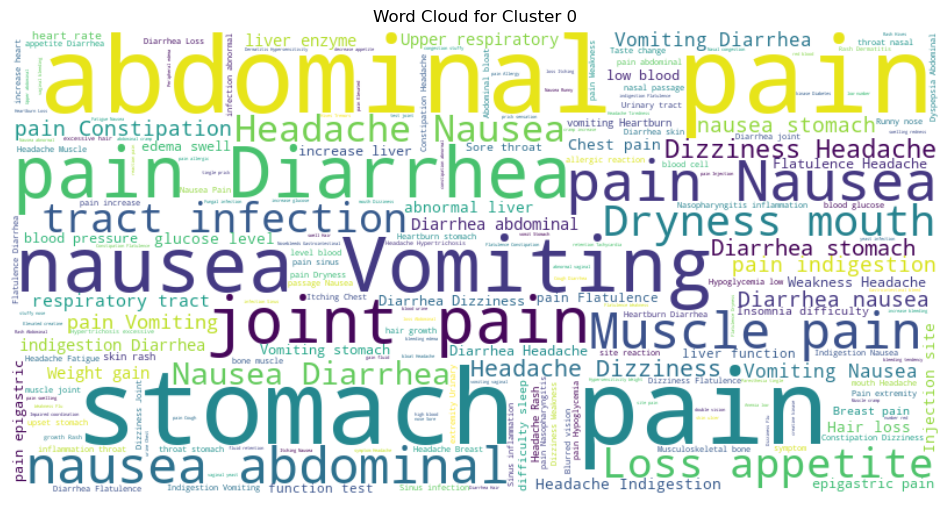

Word cloud for cluster 0 generated.
Generating word cloud for cluster 1...


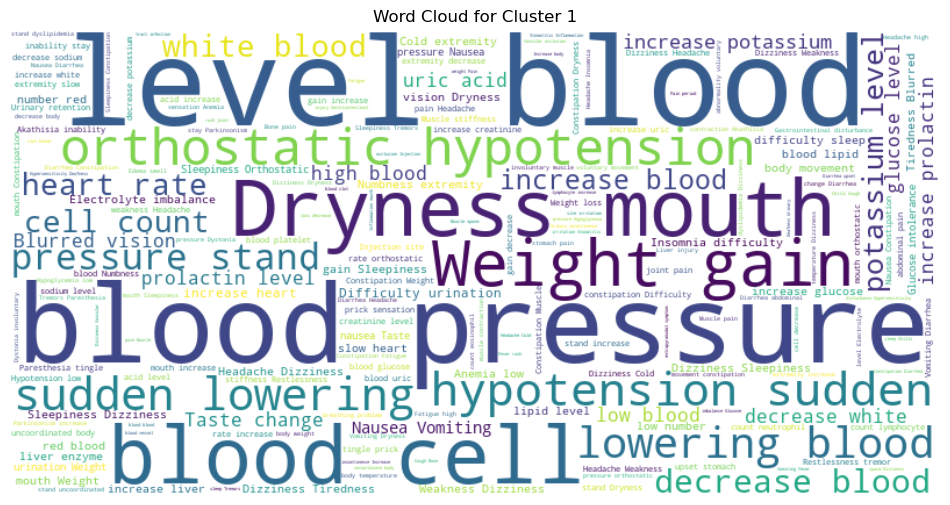

Word cloud for cluster 1 generated.
Generating word cloud for cluster 2...


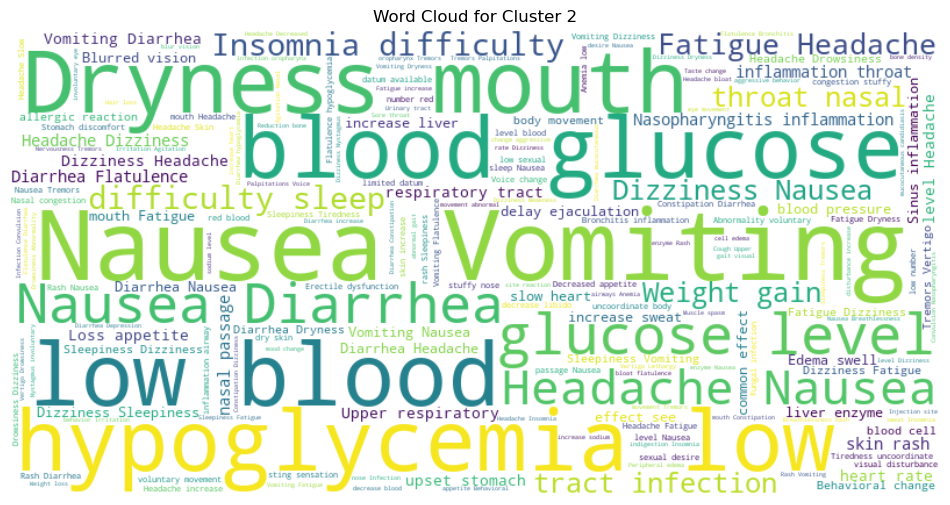

Word cloud for cluster 2 generated.
Generating word cloud for cluster 3...


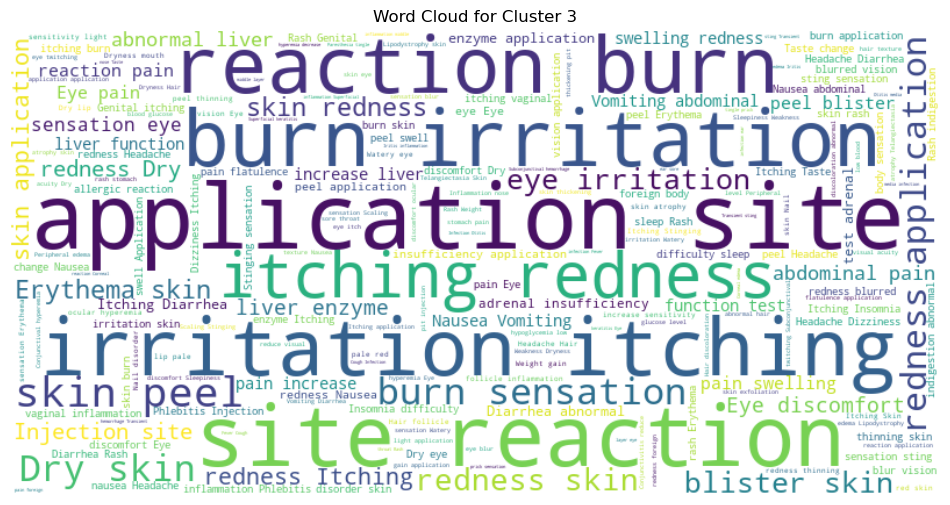

Word cloud for cluster 3 generated.
Generating word cloud for cluster 4...


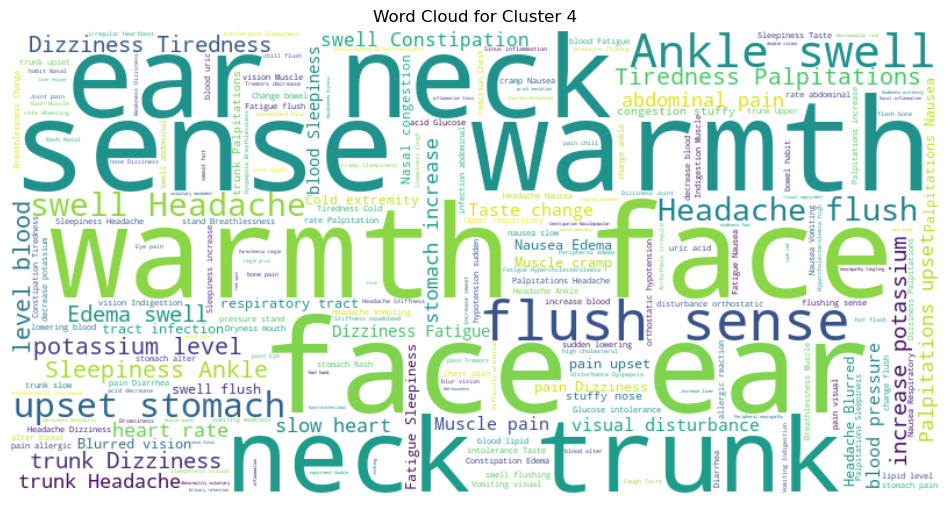

Word cloud for cluster 4 generated.


In [22]:
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

nlp = spacy.load('en_core_web_sm')
print("Loading spacy model...")
print("Model loaded.")

print("Preprocessing side effects...")
start_time = time.time()
medicine_data_cleaned['Preprocessed_Side_effects'] = medicine_data_cleaned['Side_effects'].apply(preprocess_text)
print(f"Preprocessing complete. Time taken: {time.time() - start_time:.2f} seconds")

print("Vectorizing side effects...")
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
start_time = time.time()
count_data = count_vectorizer.fit_transform(medicine_data_cleaned['Preprocessed_Side_effects'])
print(f"Vectorization complete. Time taken: {time.time() - start_time:.2f} seconds")

num_clusters = 5
print(f"Performing K-means clustering with {num_clusters} clusters...")
start_time = time.time()
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(count_data)
medicine_data_cleaned['Cluster'] = km.labels_
print(f"Clustering complete. Time taken: {time.time() - start_time:.2f} seconds")

print("Performing t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, init='random')
start_time = time.time()
tsne_result = tsne.fit_transform(count_data)
tsne_df = pd.DataFrame(tsne_result, columns=['x', 'y'])
tsne_df['Cluster'] = km.labels_
print(f"t-SNE complete. Time taken: {time.time() - start_time:.2f} seconds")

# Display the clusters
for i in range(num_clusters):
    print(f"Cluster {i}:")
    side_effects_list = medicine_data_cleaned[medicine_data_cleaned['Cluster'] == i]['Side_effects'].tolist()
    common_side_effects = pd.Series(" ".join(side_effects_list).split()).value_counts().head(10)
    print(common_side_effects)
    print("\n")

# Word clouds for each cluster
for i in range(num_clusters):
    print(f"Generating word cloud for cluster {i}...")
    cluster_text = " ".join(medicine_data_cleaned[medicine_data_cleaned['Cluster'] == i]['Preprocessed_Side_effects'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {i}')
    plt.show()
    print(f"Word cloud for cluster {i} generated.")

## 6. Sentiment Analysis

In this section, we analyze the sentiment of side effects text data using TextBlob and visualize the sentiment distribution.

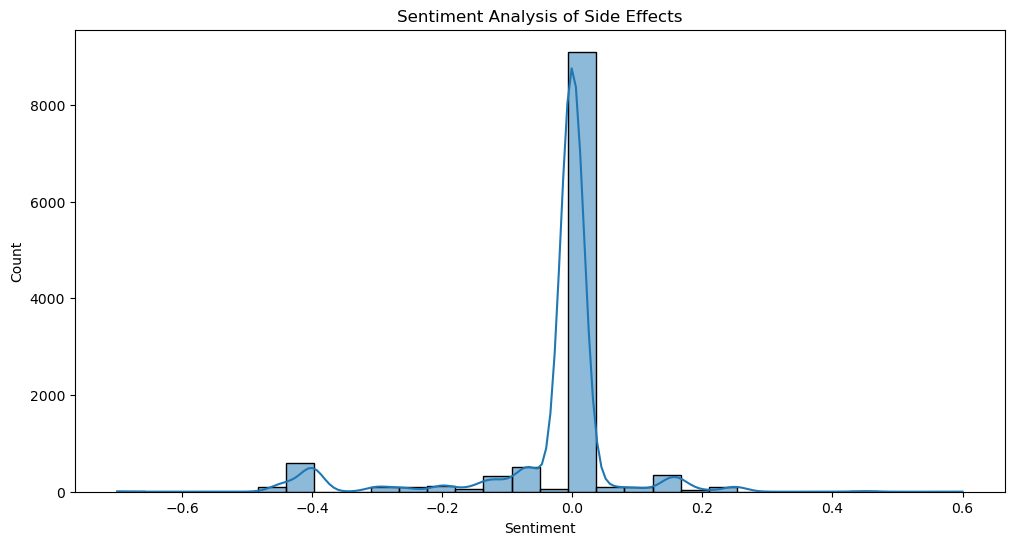

In [25]:
# Sentiment analysis of side effects using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

medicine_data_cleaned['Sentiment'] = medicine_data_cleaned['Side_effects'].apply(get_sentiment)

plt.figure(figsize=(12, 6))
sns.histplot(medicine_data_cleaned['Sentiment'], kde=True, bins=30)
plt.title('Sentiment Analysis of Side Effects')
plt.show()

## 7. Predictive Modeling

In this section, we build and evaluate Decision Tree and Random Forest models to predict composite scores based on clusters, dosages, and sentiment scores.

In [28]:
# Define features and target
X = medicine_data_cleaned[['Dosage_mg', 'Sentiment', 'Cluster']] 
y = medicine_data_cleaned['Composite Score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Decision Tree Model:
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mean Absolute Error: 11.76
Mean Squared Error: 233.52
R-squared: 0.00
Training Time: 8.68 seconds


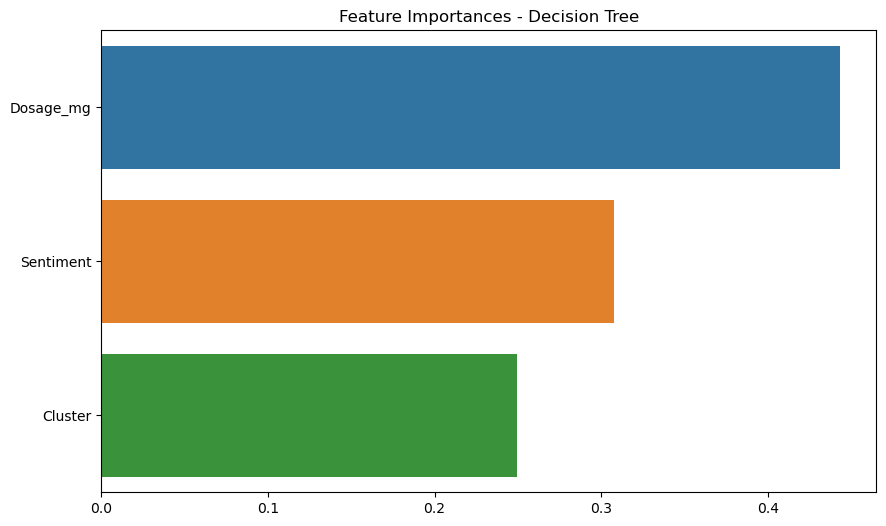

In [29]:
# Decision Tree Model with Hyperparameter Tuning
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
decision_tree = DecisionTreeRegressor(random_state=0)

grid_search_dt = GridSearchCV(estimator=decision_tree, param_grid=param_grid_dt, cv=5, n_jobs=-1, scoring='r2')
start_time = time.time()
grid_search_dt.fit(X_train, y_train)
end_time = time.time()

best_params_dt = grid_search_dt.best_params_
best_model_dt = grid_search_dt.best_estimator_

y_pred_dt = best_model_dt.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
training_time_dt = end_time - start_time

print("Decision Tree Model:")
print(f"Best Parameters: {best_params_dt}")
print(f"Mean Absolute Error: {mae_dt:.2f}")
print(f"Mean Squared Error: {mse_dt:.2f}")
print(f"R-squared: {r2_dt:.2f}")
print(f"Training Time: {training_time_dt:.2f} seconds")

feature_importances_dt = best_model_dt.feature_importances_
features = list(X.columns)  # Ensure features are in a list format

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_dt, y=features)
plt.title("Feature Importances - Decision Tree")
plt.show()



Random Forest Model:
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Absolute Error: 11.66
Mean Squared Error: 231.25
R-squared: 0.01
Training Time: 96.32 seconds


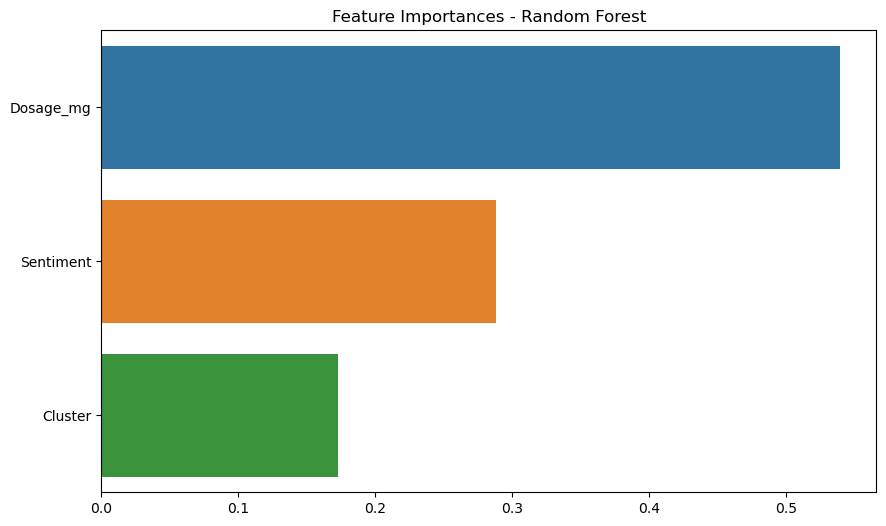

In [30]:
# Random Forest Model with Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_forest = RandomForestRegressor(random_state=0)


grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid_rf, cv=5, n_jobs=-1, scoring='r2')
start_time = time.time()
grid_search_rf.fit(X_train, y_train)
end_time = time.time()


best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_


y_pred_rf = best_model_rf.predict(X_test)


mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
training_time_rf = end_time - start_time

print("Random Forest Model:")
print(f"Best Parameters: {best_params_rf}")
print(f"Mean Absolute Error: {mae_rf:.2f}")
print(f"Mean Squared Error: {mse_rf:.2f}")
print(f"R-squared: {r2_rf:.2f}")
print(f"Training Time: {training_time_rf:.2f} seconds")


feature_importances_rf = best_model_rf.feature_importances_


plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf, y=features)
plt.title("Feature Importances - Random Forest")
plt.show()

           Model        MAE         MSE        R2  Training Time (s)
0  Decision Tree  11.763780  233.515982  0.000608           8.683984
1  Random Forest  11.656475  231.251601  0.010299          96.316433


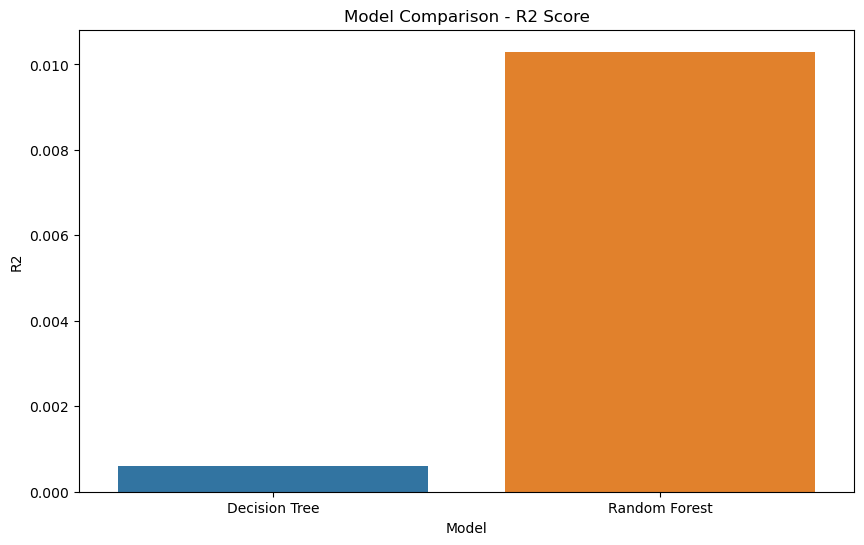

In [31]:
# Comparison of Decision Tree and Random Forest models

models_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'MAE': [mae_dt, mae_rf],
    'MSE': [mse_dt, mse_rf],
    'R2': [r2_dt, r2_rf],
    'Training Time (s)': [training_time_dt, training_time_rf]
})

print(models_comparison)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=models_comparison)
plt.title("Model Comparison - R2 Score")
plt.show()

Index(['Medicine Name', 'Composition', 'Uses', 'Side_effects', 'Manufacturer',
       'Excellent Review %', 'Average Review %', 'Poor Review %',
       'Composite Score', 'Dosage_mg', 'Cleaned_Composition',
       'Preprocessed_Side_effects', 'Cluster', 'Sentiment'],
      dtype='object')
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest Model for Top 20 Manufacturers:
Mean Absolute Error: 10.20
Mean Squared Error: 184.91
R-squared: 0.03
Training Time: 0.86 seconds


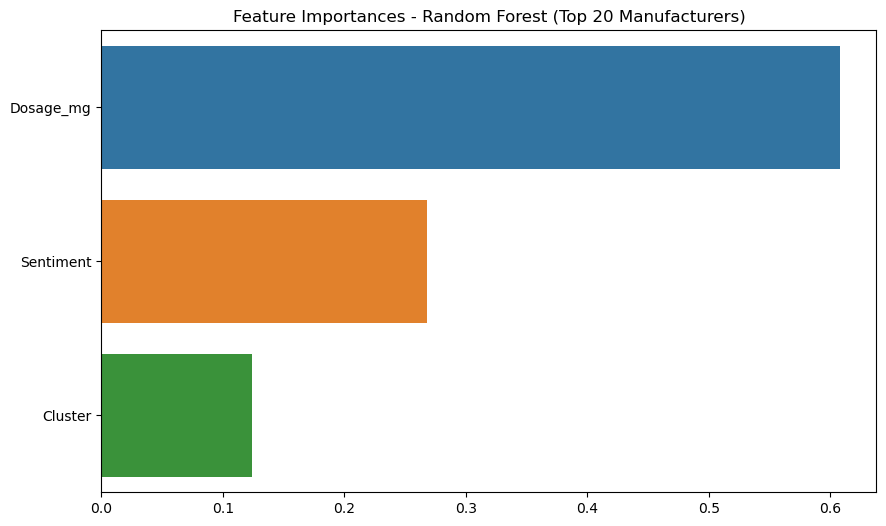

In [32]:
top_20_manufacturers = [
    'Sun Pharmaceutical Industries Ltd', 'Intas Pharmaceuticals Ltd', 'Cipla Ltd', 'Torrent Pharmaceuticals Ltd',
    'Lupin Ltd', 'Mankind Pharma Ltd', 'Zydus Cadila', 'Alkem Laboratories Ltd', 'Macleods Pharmaceuticals Pvt Ltd',
    'Abbott', 'Micro Labs Ltd', 'Dr Reddy\'s Laboratories Ltd', 'Ipca Laboratories Ltd', 'Aristo Pharmaceuticals Pvt Ltd',
    'Glenmark Pharmaceuticals Ltd', 'Alembic Pharmaceuticals Ltd', 'Leeford Healthcare Ltd', 'Eris Lifesciences Ltd',
    'Systopic Laboratories Pvt Ltd', 'USV Ltd'
]

# Filter the data
top_20_data = medicine_data_cleaned[medicine_data_cleaned['Manufacturer'].isin(top_20_manufacturers)]

# Ensure the required columns are present
print(top_20_data.columns)

# Define features and target
X_top_20 = top_20_data[['Dosage_mg', 'Sentiment', 'Cluster']]
y_top_20 = top_20_data['Composite Score']

# Train-test split
X_train_top_20, X_test_top_20, y_train_top_20, y_test_top_20 = train_test_split(X_top_20, y_top_20, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=0)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_top_20, y_train_top_20)

# Best parameters from grid search
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predictions
y_pred_rf_top_20 = best_rf.predict(X_test_top_20)

# Evaluation
mae_rf_top_20 = mean_absolute_error(y_test_top_20, y_pred_rf_top_20)
mse_rf_top_20 = mean_squared_error(y_test_top_20, y_pred_rf_top_20)
r2_rf_top_20 = r2_score(y_test_top_20, y_pred_rf_top_20)
training_time_rf_top_20 = grid_search.refit_time_

print("Random Forest Model for Top 20 Manufacturers:")
print(f"Mean Absolute Error: {mae_rf_top_20:.2f}")
print(f"Mean Squared Error: {mse_rf_top_20:.2f}")
print(f"R-squared: {r2_rf_top_20:.2f}")
print(f"Training Time: {training_time_rf_top_20:.2f} seconds")

# Feature Importance
feature_importances_rf_top_20 = best_rf.feature_importances_
features = ['Dosage_mg', 'Sentiment', 'Cluster']

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf_top_20, y=features)
plt.title("Feature Importances - Random Forest (Top 20 Manufacturers)")
plt.show()

In [ ]:
# Function to get user input
def get_user_input():
    try:
        dosage_mg = float(input("Enter the dosage in mg: "))
        sentiment = float(input("Enter the sentiment score (-1 to 1): "))
        cluster = int(input("Enter the cluster number: "))
        return dosage_mg, sentiment, cluster
    except ValueError:
        print("Invalid input. Please enter numeric values for dosage and sentiment, and an integer for cluster.")
        return get_user_input()


def predict_composite_score(model, dosage_mg, sentiment, cluster):
    input_data = pd.DataFrame({
        'Dosage_mg': [dosage_mg],
        'Sentiment': [sentiment],
        'Cluster': [cluster]
    })
    prediction = model.predict(input_data)
    return prediction[0]


def main():
    dosage_mg, sentiment, cluster = get_user_input()
    
    
    rf_prediction = predict_composite_score(random_forest, dosage_mg, sentiment, cluster)
    print(f"Random Forest Prediction: {rf_prediction}")
    
    dt_prediction = predict_composite_score(decision_tree, dosage_mg, sentiment, cluster)
    print(f"Decision Tree Prediction: {dt_prediction}")


main()
